In [1]:
import sys 
sys.path.append('../scripts/')
from robot import *
from scipy.stats import multivariate_normal

In [2]:
class Particle: ###Particle5
    def __init__(self, init_pose):
        self.pose = init_pose
        
    def motion_update(self, nu, omega, time, noise_rate_pdf): #追加
        ns = noise_rate_pdf.rvs() #順にnn, no, on, oo
        pnu = nu + ns[0]*math.sqrt(abs(nu)/time) + ns[1]*math.sqrt(abs(omega)/time)
        pomega = omega + ns[2]*math.sqrt(abs(nu)/time) + ns[3]*math.sqrt(abs(omega)/time)
        self.pose = IdealRobot.state_transition(pnu, pomega, time, self.pose)

In [3]:
class Mcl: 
    def __init__(self, init_pose, num, motion_noise_stds): 
        self.particles = [Particle(init_pose) for i in range(num)]
        
        v = motion_noise_stds
        c = np.diag([v["nn"]**2, v["no"]**2, v["on"]**2, v["oo"]**2])
        self.motion_noise_rate_pdf = multivariate_normal(cov=c)
        
    def motion_update(self, nu, omega, time): ###Mcl5###
        for p in self.particles: p.motion_update(nu, omega, time, self.motion_noise_rate_pdf)
        
    def draw(self, ax, elems): 
        xs = [p.pose[0] for p in self.particles]
        ys = [p.pose[1] for p in self.particles]
        vxs = [math.cos(p.pose[2]) for p in self.particles] 
        vys = [math.sin(p.pose[2]) for p in self.particles] 
        elems.append(ax.quiver(xs, ys, vxs, vys, color="blue", alpha=0.5))

In [4]:
class MclAgent(Agent):        ###MclAgent5
    def __init__(self, time_interval, nu, omega, particle_pose, particle_num=100,\
                motion_noise_stds={"nn":0.01, "no":0.02, "on":0.03, "oo":0.04}):
        super().__init__(nu, omega)
        self.mcl = Mcl(particle_pose, particle_num, motion_noise_stds)
        self.time_interval = time_interval
        
        self.prev_nu = 0.0       #追加
        self.prev_omega = 0.0 #追加
        
    def decision(self, observation=None): #追加
        self.mcl.motion_update(self.prev_nu, self.prev_omega, self.time_interval)
        self.prev_nu, self.prev_omega = self.nu, self.omega
        return self.nu, self.omega
        
    def draw(self, ax, elems):
        self.mcl.draw(ax, elems)

In [5]:
initial_pose = np.array([0, 0, 0]).T   ###mcl5_test（下の出力の先頭数行を記載）
a = MclAgent(0.1, 0.2, 10.0/180*math.pi, initial_pose)
a.mcl.motion_update(0.2, 10.0/180*math.pi, 0.1)
for p in a.mcl.particles:
    print(p.pose)

[ 0.01947829  0.00014802  0.01519801]
[ 0.02117891  0.00018829  0.01778035]
[  1.36206647e-02   3.00500351e-05   4.41241114e-03]
[ 0.022031    0.00031674  0.02875193]
[  2.13147639e-02  -1.07822146e-05  -1.01171317e-03]
[ 0.01688748  0.00019988  0.02367076]
[ 0.02042147  0.00024238  0.02373701]
[ 0.02236356  0.00023945  0.02141345]
[ 0.0186679   0.0002322   0.02487601]
[ 0.02329744  0.00028082  0.02410584]
[ 0.02274237  0.00021198  0.01864167]
[ 0.01747405  0.00014876  0.01702593]
[ 0.0208143   0.00014235  0.01367767]
[ 0.02132022  0.00020613  0.01933634]
[  1.80620586e-02   9.47737455e-05   1.04941389e-02]
[ 0.01912164  0.00011523  0.01205233]
[ 0.02356154  0.00024162  0.02050867]
[ 0.01936218  0.00025096  0.02592149]
[ 0.01708219  0.00014569  0.01705686]
[ 0.02271421  0.00025827  0.02273959]
[ 0.0187505   0.00015335  0.01635602]
[ 0.02118176  0.00025615  0.02418464]
[ 0.02375737  0.00014594  0.01228572]
[ 0.02011403  0.00022649  0.02251961]
[ 0.01916502  0.00011897  0.01241499]
[ 0.0

<IPython.core.display.Javascript object>


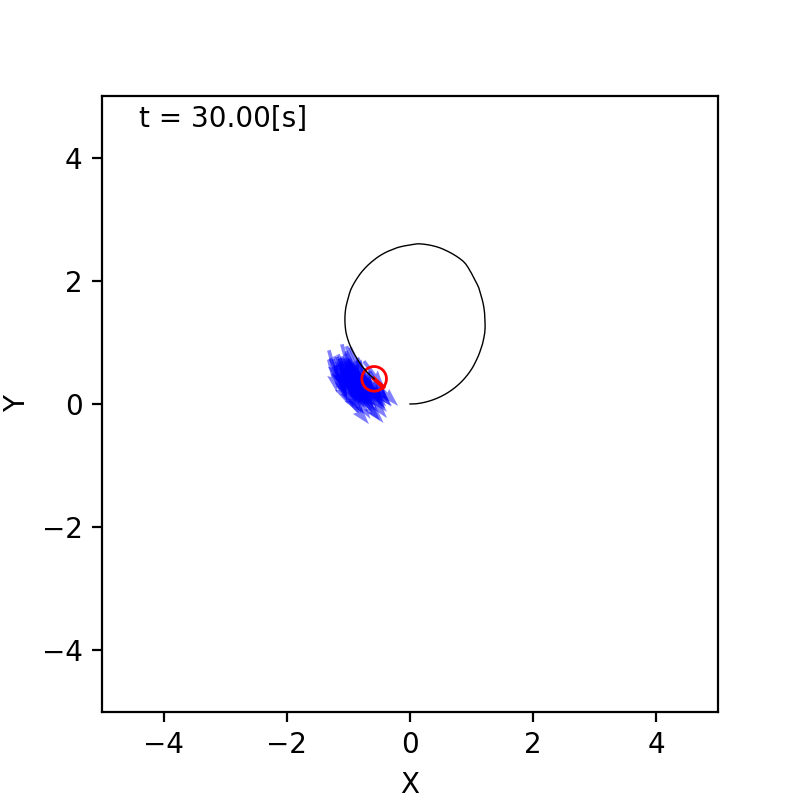

In [6]:
time_interval = 0.1  ###draw_mcl5###
world = World(30, time_interval) 

circling = MclAgent(time_interval, 0.2, 10.0/180*math.pi, np.array([0, 0, 0]).T)
r = Robot( np.array([0, 0, 0]).T, sensor=None, agent=circling, color="red" )
world.append(r)

world.draw()

<IPython.core.display.Javascript object>


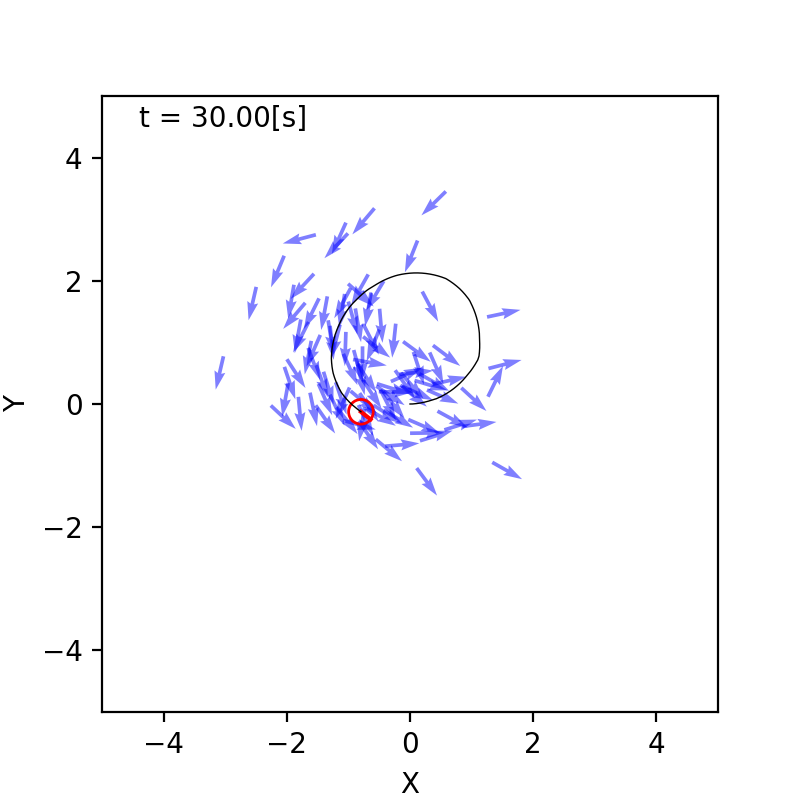

In [13]:
time_interval = 0.1  ###mcl5small###
world = World(30, time_interval) 

circling = MclAgent(time_interval, 0.2, 10.0/180*math.pi, np.array([0, 0, 0]).T, motion_noise_stds={"nn":0.1, "no":0.2, "on":0.3, "oo":0.1})
r = Robot( np.array([0, 0, 0]).T, sensor=None, agent=circling, color="red" )
world.append(r)

world.draw()